In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_09 import *

In [3]:
AvgStats

exp.nb_04.AvgStats

# Imagenette Data

In [4]:
path = untar_data(URLs.IMAGENETTE_160)

In [7]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [8]:
cbfs = [CudaCallback, Recorder,
       partial(AvgStatsCallback, accuracy),
       partial(BatchTransformXCallback, norm_imagenette)]

In [9]:
nfs = [32] * 4

In [10]:
#export
def param_getter(m): return m.parameters()

In [19]:
#export
class Learner():
    def __init__(self, model, data, loss_func, opt_func=sgd_opt, lr=1e-2, splitter=param_getter, cbs=None, cb_funcs=None):
        self.model, self.data, self.loss_func, self.opt_func, self.lr, self.splitter = model, data, loss_func, opt_func, lr, splitter
        self.in_train, self.logger, self.opt = False, print, None
        
        self.cbs = []
        self.add_cb(TrainEvalCallback())
        self.add_cbs(cbs)
        self.add_cbs(cbf() for cbf in listify(cb_funcs))
        
    def add_cbs(self, cbs):
        for cb in listify(cbs): self.add_cb(cb)
            
    def add_cb(self, cb):
        cb.set_runner(self)
        setattr(self, cb.name, cb)
        self.cbs.append(cb)
        
    def remove_cbs(self, cbs):
        for cb in listify(cbs): self.cbs.remove(cb)
            
    def __call__(self, cb_name):
        res = False
        assert cb_name in self.ALL_CBS
        for cb in sorted(self.cbs, key=lambda o: o._order): res = cb(cb_name) and res
        return res
    
    def one_batch(self, i, xb, yb):
        try:
            self.iter = i
            self.xb, self.yb = xb, yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
            
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')
            
    def all_batches(self):
        self.iters = len(self.dl)
        try:
            for i, (xb,yb) in enumerate(self.dl): self.one_batch(i, xb, yb)
                
        except CancelEpochException: self('after_cancel_epoch')
            
    def do_begin_fit(self, epochs):
        self.epochs, self.loss = epochs, tensor(0.)
        self('begin_fit')
        
    def do_begin_epoch(self, epoch):
        self.epoch, self.dl = epoch, self.data.train_dl
        return self('begin_epoch')
    
    def fit(self, epochs, cbs=None, reset_opt=False):
        self.add_cbs(cbs)
        if reset_opt or not self.opt: self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)
            
        try:
            self.do_begin_fit(epochs)
            for epoch in range(epochs):
                if not self.do_begin_epoch(epoch): self.all_batches()
                    
                with torch.no_grad():
                    self.dl = self.data.valid_dl
                    if not self('begin_validate'): self.all_batches()
                self('after_epoch')
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.remove_cbs(cbs)
            
    ALL_CBS = {'begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step',
        'after_cancel_batch', 'after_batch', 'after_cancel_epoch', 'begin_fit',
        'begin_epoch', 'begin_validate', 'after_epoch',
        'after_cancel_train', 'after_fit'}

In [20]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics, True), AvgStats(metrics, False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
            
    def after_epoch(self):
        self.logger(self.train_stats)
        self.logger(self.valid_stats)

In [29]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, Recorder,
        partial(BatchTransformXCallback, norm_imagenette)]

In [30]:
#export
def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy, opt_func=sgd_opt, cb_funcs=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, opt_func, lr, cb_funcs=cb_funcs)

In [31]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [32]:
%time learn.fit(1)

train: [1.8218652642834512, tensor(0.3677, device='cuda:0')]
valid: [1.8177121068869426, tensor(0.3625, device='cuda:0')]
CPU times: user 14.2 s, sys: 7.44 s, total: 21.6 s
Wall time: 22.5 s


In [33]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [34]:
phases = combine_scheds([0.3, 0.7], cos_1cycle_anneal(0.2, 0.6, 0.2))
sched = ParamScheduler('lr', phases)

In [35]:
learn.fit(1, sched)

train: [1.8485747488515154, tensor(0.3441, device='cuda:0')]
valid: [1.777149930334395, tensor(0.3832, device='cuda:0')]


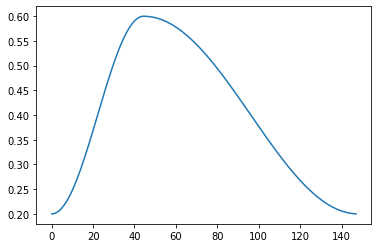

In [36]:
learn.recorder.plot_lr()

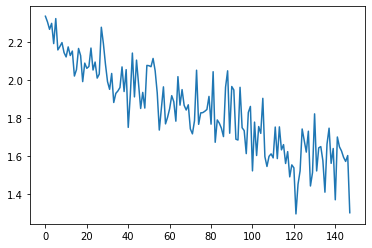

In [38]:
learn.recorder.plot_loss()